In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
!wget --no-check-certificate https://transfer.sh/XnpD8/Flower.zip -O /tmp/Flower.zip


Redirecting output to ‘wget-log’.

Redirecting output to ‘wget-log.1’.


In [2]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
print(os.path.getsize("/tmp/Flower.zip"))
import os
from google.colab import drive
drive.mount('/content/drive')

429184371
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import zipfile
local_zip = '/tmp/Flower.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
os.listdir('/tmp')
if not os.path.exists("/content/drive/My Drive/Colab Notebooks/Dataset"):
  import shutil
  SOURCE = "/tmp/Dataset"
  DESTINATION = "/content/drive/My Drive/Colab Notebooks/Dataset"
  # create a backup directory
  shutil.copytree(SOURCE, DESTINATION)
  print os.listdir(DESTINATION)
os.listdir("/content/drive/My Drive/Colab Notebooks/Dataset/")

from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
last_layer = pre_trained_model.get_layer('mixed7')
print 'last layer output shape:', last_layer.output_shape
last_output = last_layer.output

from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final softmax layer for classification
x = layers.Dense(3, activation='softmax')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])


from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Define our example directories and files
base_dir = '/content/drive/My Drive/Colab Notebooks/Dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        # class_mode='binary'
        class_mode = 'categorical'
        )
    

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=5,
        #class_mode='binary'
        class_mode = 'categorical'
        )

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=1,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

# Further tuning
from tensorflow.keras.optimizers import SGD

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(
                  lr=0.00001, 
                  momentum=0.9),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=1,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

# %matplotlib inline

# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# # Retrieve a list of accuracy results on training and test data
# # sets for each training epoch
# acc = history.history['acc']
# val_acc = history.history['val_acc']

# # Retrieve a list of list results on training and test data
# # sets for each training epoch
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# # Get number of epochs
# epochs = range(len(acc))

# # Plot training and validation accuracy per epoch
# plt.plot(epochs, acc)
# plt.plot(epochs, val_acc)
# plt.title('Training and validation accuracy')

# plt.figure()

# # Plot training and validation loss per epoch
# plt.plot(epochs, loss)
# plt.plot(epochs, val_loss)
# plt.title('Training and validation loss')

last layer output shape: (None, 7, 7, 768)
Found 272 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Epoch 1/1
 - 536s - loss: 0.2535 - acc: 0.9108 - val_loss: 0.1397 - val_acc: 0.9640
Epoch 1/1
 - 383s - loss: 0.0433 - acc: 0.9843 - val_loss: 0.1218 - val_acc: 0.9680


Computer thinks this is a: HOA HONG DO


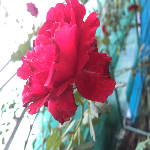

In [6]:
from PIL import Image
import numpy as np

list_of_labels = os.listdir(train_dir)
list_of_labels = sorted(list_of_labels)

# Make this more efficient. Let's rename the file to the name of prediction
for label in list_of_labels:
    folder_path = validation_dir + "/" + label
    list_of_files = os.listdir(folder_path)
    for index, file in enumerate(list_of_files):
        file_path = folder_path + "/" + file
        img = Image.open(file_path)
        img_resize = img.resize((150,150))
        np_image = np.array(img_resize)
        np_image = np_image.reshape(1,150,150,3) * 1./255
        id_predict = np.argmax(model.predict(np_image))
        confidence = int(round(np.max(model.predict(np_image)) * 100))
        prediction = list_of_labels[id_predict]
        os.rename(file_path,folder_path + "/" + str(index) + "_" + prediction + "_" + str(confidence) + ".JPG")
        
        
# Make this more efficient. Let's rename the file to the name of prediction
for label in list_of_labels:
    folder_path = train_dir + "/" + label
    list_of_files = os.listdir(folder_path)
    for index, file in enumerate(list_of_files):
        file_path = folder_path + "/" + file
        img = Image.open(file_path)
        img_resize = img.resize((150,150))
        np_image = np.array(img_resize)
        np_image = np_image.reshape(1,150,150,3) * 1./255
        id_predict = np.argmax(model.predict(np_image))
        confidence = int(round(np.max(model.predict(np_image)) * 100))
        prediction = list_of_labels[id_predict]
        os.rename(file_path,folder_path + "/" + str(index) + "_" + prediction + "_" + str(confidence) + ".JPG")

        
# pick a file in HOA HONG DO
rose_file_names = os.listdir("/content/drive/My Drive/Colab Notebooks/Dataset/validation/HOA HONG DO/")

img = Image.open("/content/drive/My Drive/Colab Notebooks/Dataset/validation/HOA HONG DO/" + rose_file_names[4])
img_resize = img.resize((150,150))
np_image = np.array(img_resize)
np_image = np_image.reshape(1,150,150,3) * 1./255

id_predict = np.argmax(model.predict(np_image))
prediction = list_of_labels[id_predict]
print("Computer thinks this is a: {}".format(prediction))        
img_resize

Computer thinks this is a: HOA DAM BUT


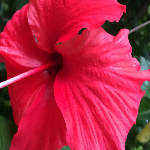

In [8]:
# pick a file in HOA DAM BUT
file_names = os.listdir("/content/drive/My Drive/Colab Notebooks/Dataset/validation/HOA DAM BUT/")

img = Image.open("/content/drive/My Drive/Colab Notebooks/Dataset/validation/HOA DAM BUT/" + file_names[0])
img_resize = img.resize((150,150))
np_image = np.array(img_resize)
np_image = np_image.reshape(1,150,150,3) * 1./255

id_predict = np.argmax(model.predict(np_image))
prediction = list_of_labels[id_predict]
print("Computer thinks this is a: {}".format(prediction))        
img_resize

Computer thinks this is a: HOA XUYEN CHI


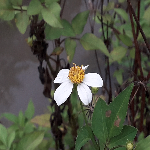

In [13]:
# pick a file in HOA DAM BUT
file_names = os.listdir("/content/drive/My Drive/Colab Notebooks/Dataset/validation/HOA XUYEN CHI/")

img = Image.open("/content/drive/My Drive/Colab Notebooks/Dataset/validation/HOA XUYEN CHI/" + file_names[0])
img_resize = img.resize((150,150))
np_image = np.array(img_resize)
np_image = np_image.reshape(1,150,150,3) * 1./255

id_predict = np.argmax(model.predict(np_image))
prediction = list_of_labels[id_predict]
print("Computer thinks this is a: {}".format(prediction))        
img_resize

In [0]:
# No need to run this for students, only for tutors.

# list_of_labels = os.listdir(train_dir)
# list_of_labels = sorted(list_of_labels)
# # Reset images' names
# for label in list_of_labels:
#     folder_path = validation_dir + "/" + label
#     list_of_files = os.listdir(folder_path)
#     for index, file in enumerate(list_of_files):
#         file_path = folder_path + "/" + file
#         os.rename(file_path,folder_path + "/Image_" + str(index) + ".JPG")
          
# # Reset images' names
# for label in list_of_labels:
#     folder_path = train_dir + "/" + label
#     list_of_files = os.listdir(folder_path)
#     for index, file in enumerate(list_of_files):
#         file_path = folder_path + "/" + file
#         os.rename(file_path,folder_path + "/Image_" + str(index) + ".JPG")